# Face Recognition System

In this notebook, we build a Face Recognition System based on LFW Face dataset

<img src='assets/task.png'>


## What we are trying to do:


<img src='assets/pre.png'>

In [1]:
import os
import datetime
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.animation as animation
import torch.nn.functional as F
import torch.utils.data as utils
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
seed=123456789
np.random.seed(seed)
torch.manual_seed(seed)

## 1. Prepare Data

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(data_home='data/',min_faces_per_person=100, resize=1)

images = lfw_people.images
targets = lfw_people.target
target_names = lfw_people.target_names

X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.4, random_state=seed, stratify=targets)
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train=torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

X_train = X_train[:, None, :, :]
X_test = X_test[:, None, :, :]

train_data = DataLoader(utils.TensorDataset(X_train, y_train), batch_size=8, shuffle=True, num_workers=2)
test_data = DataLoader(utils.TensorDataset(X_test, y_test),batch_size=8, shuffle=False, num_workers=2)

## 2. Train model

### 2.1 Network Architecture

In [3]:
class FaceNet(nn.Module):
    def __init__(self, img_h, img_w):
        super(FaceNet, self).__init__()
        self.num_maxpools = 2
        self.img_h = img_h
        self.img_w = img_w
        self.num_flatten_units = (self.img_h // (2**self.num_maxpools)) * (self.img_w // (2**self.num_maxpools))
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 20,
                               kernel_size = 5,
                               padding = 2
                              )
        self.conv2 = nn.Conv2d(in_channels = 20,
                               out_channels = 50,
                               kernel_size = 5,
                               padding = 2
                              )
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(self.num_flatten_units * 50, 500)
        self.fc2 = nn.Linear(500, 10)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        f1_map = x
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        f2_map = x
        x = self.maxpool(x)
        x = x.view(-1, self.num_flatten_units * 50)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.fc2(x)
        return f1_map, f2_map, x

In [4]:
def test(model, dataset):
    model = model.eval()
    model = model.to(DEVICE)
    running_loss = 0
    total_len = 0
    correct = 0
    with torch.no_grad():
        for batch_set in dataset:
            inputs = batch_set[0].to(DEVICE)
            outputs = batch_set[1].to(DEVICE)
            
            _, _, predictions = model(inputs)
            
            loss = CE_LOSS(predictions, outputs)
            
            running_loss += loss.item()
            total_len += len(inputs)
            
            _, predicted = torch.max(predictions.data, 1)
            correct += (predicted == outputs).sum().item()
            
    return running_loss/total_len, correct/total_len * 100

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CE_LOSS = torch.nn.CrossEntropyLoss()

EPOCHS = 5
LR = (1e-05)/2

img_shape = (125, 94)
model = FaceNet(*img_shape)

In [6]:
accuracy_dict = {'train':[], 'index':[]}
optimizer = torch.optim.Adam(model.parameters(), LR)  

print("Training Started")

for i in range(EPOCHS):
    for iteration, batch_set in enumerate(train_data):

        model = model.train()

        inputs = batch_set[0].to(DEVICE)
        outputs = batch_set[1].to(DEVICE)

        _, _, predictions = model(inputs)

        optimizer.zero_grad()

        loss = CE_LOSS(predictions, outputs)
        loss.backward()
        optimizer.step()

    train_loss, train_accuracy = test(model, train_data)

    print('{:*^75}'.format(''))
    print(datetime.datetime.now())
    print("Epoch: {}-> Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(i+1, train_loss, train_accuracy))
    print('{:*^75}'.format(''))

Training Started
***************************************************************************
2019-08-24 11:37:10.951810
Epoch: 1-> Train Loss: 0.1963, Train Accuracy: 54.0936
***************************************************************************
***************************************************************************
2019-08-24 11:37:28.431515
Epoch: 2-> Train Loss: 0.1206, Train Accuracy: 73.5380
***************************************************************************
***************************************************************************
2019-08-24 11:37:47.680953
Epoch: 3-> Train Loss: 0.0597, Train Accuracy: 82.7485
***************************************************************************
***************************************************************************
2019-08-24 11:38:05.597442
Epoch: 4-> Train Loss: 0.0277, Train Accuracy: 94.0058
***************************************************************************
***********************************************

## 3. Test Model

In [7]:
_, test_accuracy = test(model, test_data)
print("Test Accuracy: {}".format(test_accuracy))

Test Accuracy: 86.40350877192982


## 4. Use Model (Make Predictions)

We can recognize the face using face image.


In [8]:
def predict(model, img):
    model = model.eval()
    img = img.to(DEVICE)
    model = model.to(DEVICE)
    with torch.no_grad():
        _, _, prediction = model(img)
        _, prediction = torch.max(prediction.data, 1)
        return prediction

### 4.1 Taking Face Image

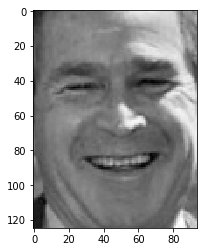

In [9]:
test_img = X_test[93].squeeze(0).numpy().astype(int)
plt.imshow(test_img, cmap="gray")

### 4.2 Doing Face Recognition

In [10]:
prediction = predict(model, X_test[93].unsqueeze(0))
print("Predicted Person: {}".format(target_names[prediction.item()]))

Predicted Person: George W Bush
